In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
import matplotlib.pyplot as plt
import h5py
import numpy as np
import get_xyz
import constants
from pathlib import Path
import hdf5plugin
import streak_finder as sf
import add_geometry_streaks
import scipy.constants as sc
import scipy.ndimage

In [2]:
def angle_filter(streaks, angle=.1):
    # angle in radians
    x0, y0, x1, y1 = streaks.T
    dx = x1 - x0
    dy = y1 - y0
    
    # filter by angle
    nh = np.array([-dy, dx]) # normal vectors
    nh = nh / (nh[0]**2 + nh[1]**2)**0.5
    
    rh = np.array([x0 + x1, y0 + y1]) / 2 # centre postions
    rh = rh / (rh[0]**2 + rh[1]**2)**0.5
    
    cos = np.sum(rh * nh, axis=0) # cosign of angle bw r0 and rh
    
    m = cos > np.cos(angle)
    return m

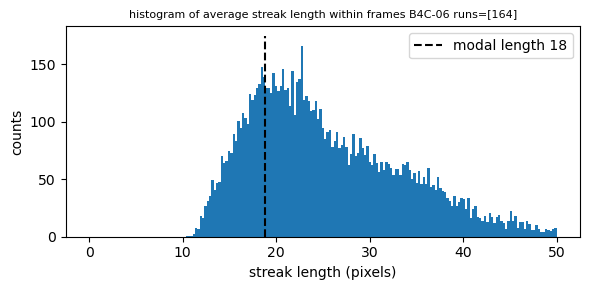

In [5]:
runs = [121]
sample = 'B4C-06'

title = f'histogram of average streak length within frames {sample} {runs=}'
file = f'streaklength_{sample}.svg'

fnams = [Path(constants.work) / f'streaks/streaks_run{run:>04}.h5' for run in runs]

streaks = []
pid = []
for fnam in fnams:
    with h5py.File(fnam) as f:
        streaks.append(f['fs0_ss0_fs1_ss1_im'][()])
        pid.append(f['pulse_id'][()])
    
streaks = np.concatenate(streaks, axis=0)
pid = np.squeeze(np.concatenate(pid, axis=0))

m = angle_filter(streaks, np.pi/32)

streaks = streaks[m]
pid = pid[m]

x0, y0, x1, y1 = streaks.T
dx = x1 - x0
dy = y1 - y0

length = (dx**2 + dy**2)**0.5

# get streak length per pattern
# unique pids labels
_, pid, n_d = np.unique(pid, return_inverse=True, return_counts=True)

# d = frame index
length_d = np.bincount(pid, weights=length) / n_d

# filter by hit
length_d = length_d[n_d > 5]

fig, ax = plt.subplots()
fig.set_size_inches(6, 3)
fig.set_tight_layout(True)

h, b, _ = ax.hist(length_d, bins=np.linspace(0, 50, 200))

# smooth to find max
h = scipy.ndimage.gaussian_filter1d(h, 3)
x = b[np.argmax(h)]
ylim = ax.get_ylim()
ax.vlines(x, ylim[0], ylim[1], color='k', linestyle='--', label=f'modal length {int(x)}')
ax.legend()
ax.set_title(title, fontsize=8)
ax.set_xlabel('streak length (pixels)')
ax.set_ylabel('counts')
#ax.set_yscale('log')
# ax.plot(length_d)
plt.savefig(file)
plt.show()

# No filter Histogram

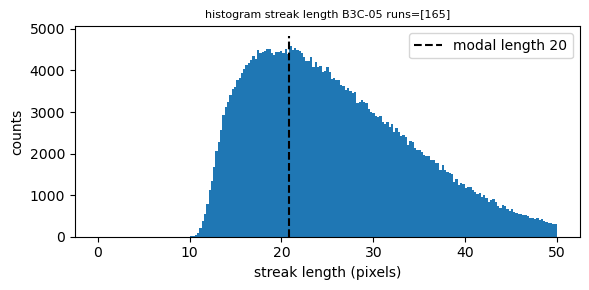

In [13]:
runs = [165]
sample = 'B3C-05'

title = f'histogram streak length {sample} {runs=}'
file = f'streaklength_no_filter_{sample}.svg'

fnams = [Path(constants.work) / f'streaks_ahmed/streaks_run{run:>04}.h5' for run in runs]

streaks = []
for fnam in fnams:
    with h5py.File(fnam) as f:
        streaks.append(f['fs0_ss0_fs1_ss1_slab'][()])
    
streaks = np.concatenate(streaks, axis=0)

x0, y0, x1, y1 = streaks.T
dx = x1 - x0
dy = y1 - y0

length = (dx**2 + dy**2)**0.5

fig, ax = plt.subplots()
fig.set_size_inches(6, 3)
fig.set_tight_layout(True)

h, b, _ = ax.hist(length, bins=np.linspace(0, 50, 200))

# smooth to find max
h = scipy.ndimage.gaussian_filter1d(h, 3)
x = b[np.argmax(h)]
ylim = ax.get_ylim()
ax.vlines(x, ylim[0], ylim[1], color='k', linestyle='--', label=f'modal length {int(x)}')
ax.legend()
ax.set_title(title, fontsize=8)
ax.set_xlabel('streak length (pixels)')
ax.set_ylabel('counts')
#ax.set_yscale('log')
# ax.plot(length_d)
plt.savefig(file)
plt.show()

# overlaping histograms

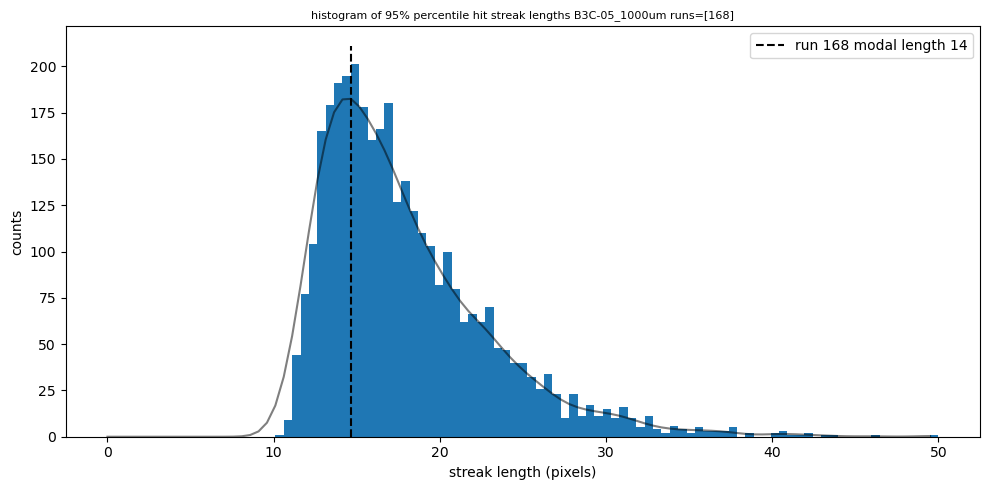

In [54]:
runs = [167, 166, 164, 165]

runs = [168]
sample = 'B3C-05_1000um'

title = f'histogram of 95% percentile hit streak lengths {sample} {runs=}'
file = f'streaklength_percentile_{sample}.svg'

# fnams = [Path(constants.work) / f'streaks_ahmed/streaks_run{run:>04}.h5' for run in runs]

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
fig.set_tight_layout(True)

for run in runs:
    # do this for each sub-file
    fnams = Path(constants.work).glob(f'streaks_ahmed/streaks_run{run:>04}_file*.h5')

    lengths = []
    for fnam in fnams:
        with h5py.File(fnam) as f:
            streaks = f['streaks'][()]
            pid = f['streak_ids'][()]

            # is hit?
            pid_u, n_d = np.unique(pid, return_counts=True)
            
            x0, y0, x1, y1 = streaks.T
            dx = x1 - x0
            dy = y1 - y0
            length = (dx**2 + dy**2)**0.5

            for p in pid_u[n_d>15]:
                i = np.where(p == pid)[0]

                # stor the n'th percentile of streak lengths in frame
                lengths.append(np.percentile(length[i], 95))

    h, b, p = ax.hist(length, bins=np.linspace(0, 50, 100), alpha=1)
    # smooth to find max
    h = scipy.ndimage.gaussian_filter1d(h, 2)
    ax.plot(b[:-1], h, c='k', alpha=0.5)
    x = b[np.argmax(h)]
    ylim = ax.get_ylim()
    ax.vlines(x, ylim[0], ylim[1], color='k', linestyle='--', label=f'run {run} modal length {int(x)}')
ax.legend()
ax.set_title(title, fontsize=8)
ax.set_xlabel('streak length (pixels)')
ax.set_ylabel('counts')
#ax.set_yscale('log')
# ax.plot(length_d)
plt.savefig(file)
plt.show()

# Ahmed streaks

In [25]:
runs = [165]
sample = 'B3C-05'

title = f'histogram streak length {sample} {runs=}'
file = f'streaklength_no_filter_{sample}.svg'

# fnams = [Path(constants.work) / f'streaks_ahmed/streaks_run{run:>04}.h5' for run in runs]

fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
fig.set_tight_layout(True)

for run in runs:
    # do this for each sub-file
    fnams = Path(constants.work).glob(f'streaks_ahmed/streaks_run{run:>04}_file*.h5')

    lengths = []
    for fnam in fnams:
        with h5py.File(fnam) as f:
            streaks = f['streaks'][()]
            pid = f['streak_ids'][()]

            # is hit?
            pid_u, n_d = np.unique(pid, return_counts=True)
            
            x0, y0, x1, y1 = streaks.T
            dx = x1 - x0
            dy = y1 - y0
            length = (dx**2 + dy**2)**0.5

            for p in pid_u[n_d>15]:
                i = np.where(p == pid)[0]

                # stor the n'th percentile of streak lengths in frame
                lengths.append(np.percentile(length[i], 95))

    if run == 165:
        alpha = 0.3
    else:
        alpha = .8
    h, b, p = ax.hist(length, bins=np.linspace(0, 50, 100), alpha=alpha)
    # smooth to find max
    h = scipy.ndimage.gaussian_filter1d(h, 2)
    x = b[np.argmax(h)]
    ylim = ax.get_ylim()
    ax.vlines(x, ylim[0], ylim[1], color=p.get_children()[0].get_facecolor(), linestyle='-', label=f'run {run} modal length {int(x)}')
ax.legend()
ax.set_title(title, fontsize=8)
ax.set_xlabel('streak length (pixels)')
ax.set_ylabel('counts')
#ax.set_yscale('log')
# ax.plot(length_d)
plt.savefig(file)
plt.show()

(0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 0.4)